In [11]:

pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [14]:
import pandas as pd

df = pd.read_csv("healthcare_dataset_cleaned.csv")

# Convert dates to datetime (they may load as strings)
df["Date of Admission"] = pd.to_datetime(df["Date of Admission"], errors="coerce")
df["Discharge Date"] = pd.to_datetime(df["Discharge Date"], errors="coerce")

print("Dataset loaded successfully.")
print(df.head())


Dataset loaded successfully.
            Name  Age  Gender Blood Type Medical Condition Date of Admission  \
0  Bobby JacksOn   30    Male         B-            Cancer        2024-01-31   
1   LesLie TErRy   62    Male         A+           Obesity        2019-08-20   
2    DaNnY sMitH   76  Female         A-           Obesity        2022-09-22   
3   andrEw waTtS   28  Female         O+          Diabetes        2020-11-18   
4  adrIENNE bEll   43  Female        AB+            Cancer        2022-09-19   

             Doctor                    Hospital Insurance Provider  \
0     Matthew Smith             Sons and Miller         Blue Cross   
1   Samantha Davies                     Kim Inc           Medicare   
2  Tiffany Mitchell                    Cook PLC              Aetna   
3       Kevin Wells  Hernandez Rogers and Vang,           Medicare   
4    Kathleen Hanna                 White-White              Aetna   

   Billing Amount  Room Number Admission Type Discharge Date   Medica

---- Length of Stay Created ----
  Date of Admission Discharge Date  Length of Stay
0        2024-01-31     2024-02-02               2
1        2019-08-20     2019-08-26               6
2        2022-09-22     2022-10-07              15
3        2020-11-18     2020-12-18              30
4        2022-09-19     2022-10-09              20


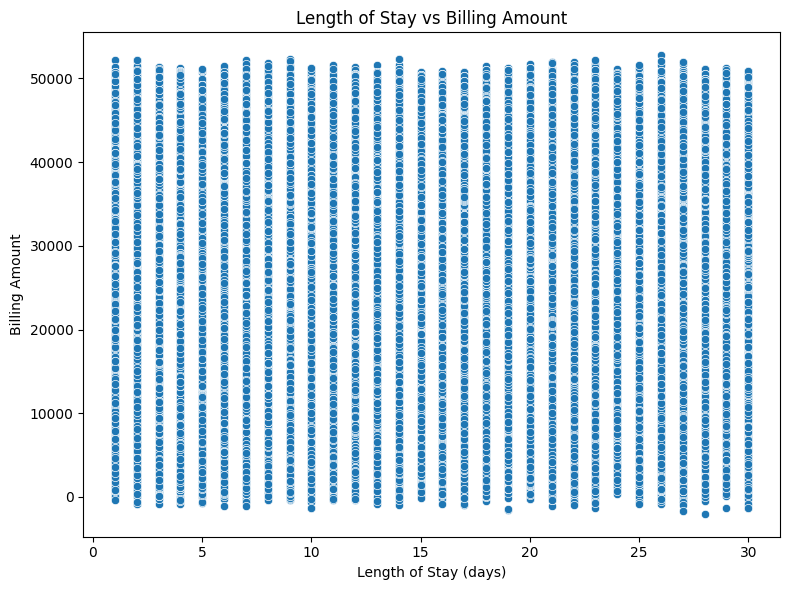

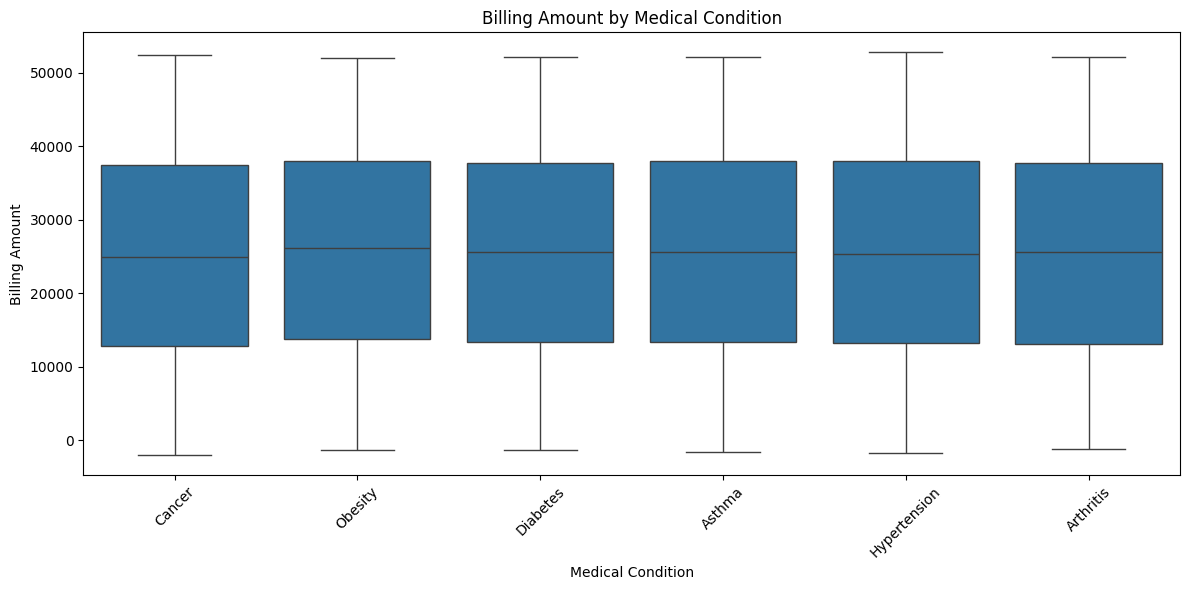

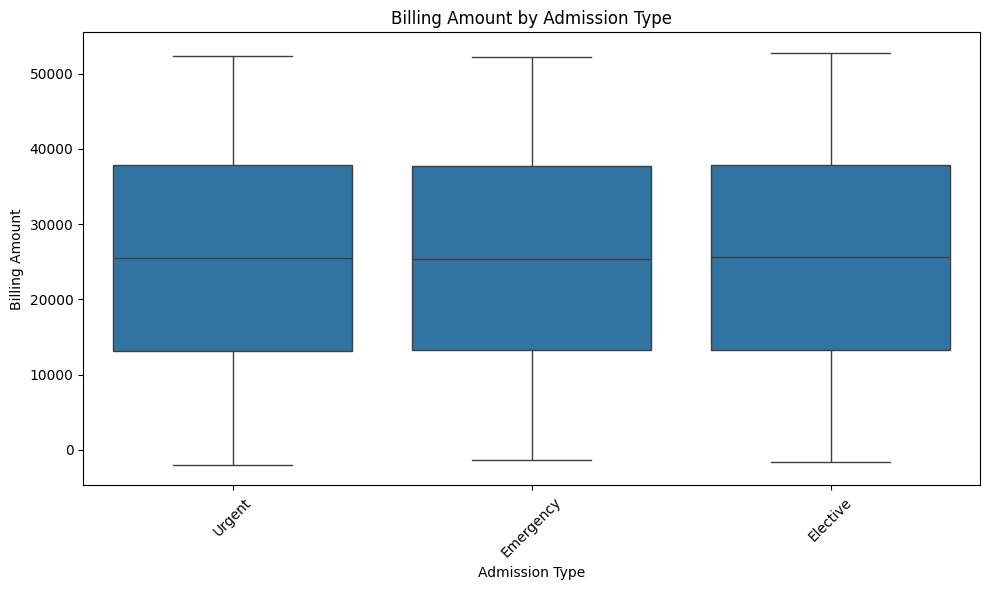

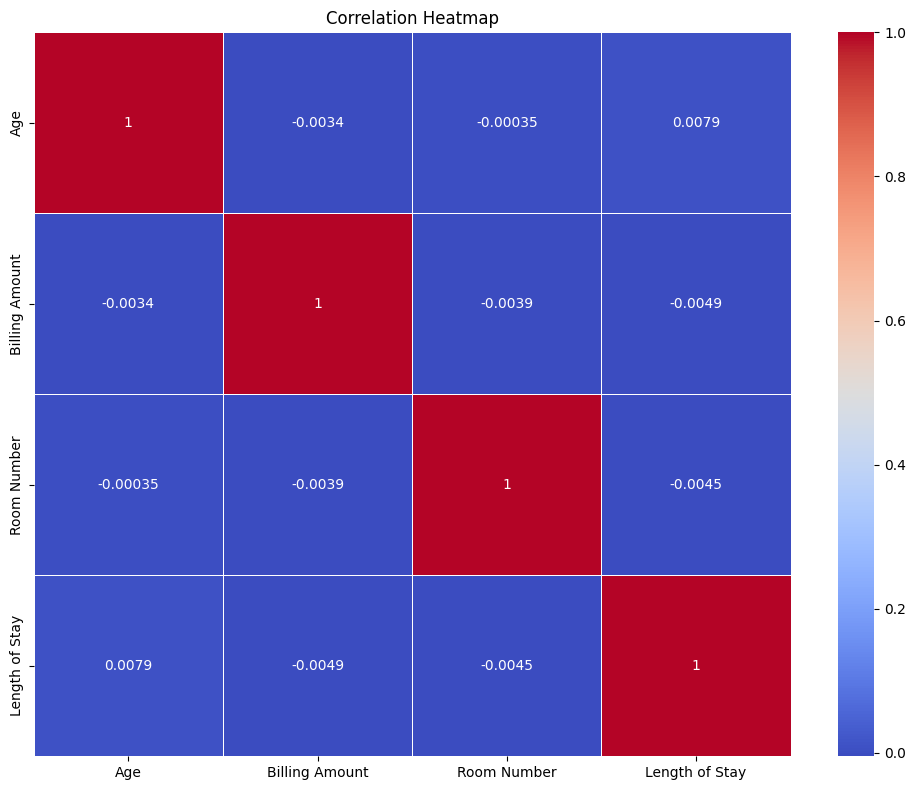

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create Length of Stay
df["Length of Stay"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days

print("---- Length of Stay Created ----")
print(df[["Date of Admission", "Discharge Date", "Length of Stay"]].head())


# 2A. Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Length of Stay", y="Billing Amount")
plt.title("Length of Stay vs Billing Amount")
plt.xlabel("Length of Stay (days)")
plt.ylabel("Billing Amount")
plt.tight_layout()
plt.show()


# 2B. Box Plot by Medical Condition
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Medical Condition", y="Billing Amount")
plt.title("Billing Amount by Medical Condition")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2C. Box Plot by Admission Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Admission Type", y="Billing Amount")
plt.title("Billing Amount by Admission Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 3. Correlation Heatmap
numeric_df = df.select_dtypes(include=["float64", "int64"])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [19]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [31]:
df = pd.read_csv("healthcare_dataset_cleaned.csv")

# Convert dates again
df["Date of Admission"] = pd.to_datetime(df["Date of Admission"], errors="coerce")
df["Discharge Date"] = pd.to_datetime(df["Discharge Date"], errors="coerce")

print("✅ df reset. Shape:", df.shape)


✅ df reset. Shape: (54966, 15)


In [ ]:
# ==========================================
# MODULE 2: FEATURE ENGINEERING + PREP
# ==========================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

print("\n===== MODULE 2: FEATURE ENGINEERING =====\n")

# --------------------------------------------------
# 1. FIX DATE COLUMNS & CREATE LENGTH OF STAY
# --------------------------------------------------

# Convert to datetime
date_cols = ["Date of Admission", "Discharge Date"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Create Length of Stay
df["Length of Stay"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days

print("✅ Length of Stay created successfully.\n")


# --------------------------------------------------
# 2. OUTLIER DETECTION (IQR METHOD)
# --------------------------------------------------

def detect_outliers_iqr(df, columns):
    outlier_summary = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)].index
        outlier_summary[col] = list(outliers)
        print(f"{col}: {len(outliers)} outliers detected.")
    return outlier_summary

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
outliers = detect_outliers_iqr(df, numeric_cols)

print("\n✅ Outlier detection completed.\n")


# --------------------------------------------------
# 3. HANDLE CATEGORICAL ENCODING (SMART + SAFE)
# --------------------------------------------------

object_cols = df.select_dtypes(include="object").columns.tolist()
print("Object columns found:", object_cols)

# Label Encode small-cardinality columns (<=10 unique)
label_encode_cols = [col for col in object_cols if df[col].nunique() <= 10]

# Target Encode high-cardinality columns (>10 unique)
target_encode_cols = [col for col in object_cols if df[col].nunique() > 10]

# ---- Label Encoding ----
le = LabelEncoder()
for col in label_encode_cols:
    df[col] = le.fit_transform(df[col])
print("\nLabel Encoded:", label_encode_cols)

# ---- Target Encoding ----
for col in target_encode_cols:
    means = df.groupby(col)["Billing Amount"].mean()
    df[col] = df[col].map(means)
print("Target Encoded:", target_encode_cols)

print("\n✅ All categorical encoding completed successfully.\n")


# --------------------------------------------------
# 4. PREPARE FINAL NUMERIC FEATURE MATRIX
# --------------------------------------------------

y = df["Billing Amount"]

# Drop target and any impossible features
X = df.drop(["Billing Amount"], axis=1)

# Convert DATETIME → numeric timestamps
datetime_cols = X.select_dtypes(include=["datetime64[ns]"]).columns
for col in datetime_cols:
    X[col] = X[col].astype("int64") // 10**9

# Ensure ALL features numeric
X = X.select_dtypes(include=[np.number])

print("✅ Final feature matrix prepared (numeric only).")
print(f"Final number of features: {X.shape[1]}\n")


# --------------------------------------------------
# 5. FEATURE SELECTION (Random Forest Importance)
# --------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("✅ Random Forest Feature Importance Computed.\n")
print(feature_importances.head(20))



===== MODULE 2: FEATURE ENGINEERING =====

✅ Length of Stay created successfully.

Age: 0 outliers detected.
Billing Amount: 0 outliers detected.
Room Number: 0 outliers detected.
Length of Stay: 0 outliers detected.

✅ Outlier detection completed.

Object columns found: ['Name', 'Gender', 'Blood Type', 'Medical Condition', 'Doctor', 'Hospital', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']

Label Encoded: ['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']
Target Encoded: ['Name', 'Doctor', 'Hospital']

✅ All categorical encoding completed successfully.

✅ Final feature matrix prepared (numeric only).
Final number of features: 15

✅ Random Forest Feature Importance Computed.

               Feature    Importance
0                 Name  9.998423e-01
7             Hospital  8.977689e-05
6               Doctor  5.529903e-05
12          Medication  2.100144e-06
9          Room Number  2.038341e-06
10 